### Exploring the USA's Aerospace Industry Imports and Exports

by Tony Hirst, Michel Wermelinger and Bryan Novy 19 November 2015, 28 March 2016, 9 July 2016

This is the project notebook for Week 4 of The Open University's [_Learn to Code for Data Analysis_](http://futurelearn.com/courses/learn-to-code) course.

The United States is often assumed to now be a nation of importers, having shut down its manufacturing sectors decades ago. This is a misconception, however, as the US is one of the leaders in designing and manufacturing aircraft and associated parts. This article will examine the trade flows of aerospace technology into and out of the United States in 2015.

Foreign trade is often one of the largest and most critically important aspects of a nation's economy. Changes to a nation's imports and exports can have a drastic effect on economic growth. This makes trade one of the most interesting fields of economics to study.

One useful source for global trade data is the United Nations Comtrade database, and will be the source for the data in this article.

Some questions that will be addressed here:

What is the state of US trade balance in terms of the aerospace industry? Does it export more or import more? Who are America's top aerospace trade partners? Are there countries that the US both exports to and imports from?

In [54]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from pandas import *

import pandas as pd
from pandas import Series,DataFrame

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

## Getting and preparing the data

The data is obtained from the [United Nations Comtrade](http://comtrade.un.org/data/) website, by selecting the following configuration:

- Type of Product: goods
- Frequency: monthly 
- Periods: January to December of 2015
- Reporter: United States
- Partners: all
- Flows: imports and exports
- HS (as reported) commodity codes: 88 Aircraft, spacecraft, and parts thereof. 840710 Aircraft Engines, spark-ignition’

Clicking on 'Preview' results in a message that the data exceeds 500 rows. Data was downloaded using the *Download CSV* button and the download file renamed appropriately.

In [55]:
LOCATION = 'comtrade_US_Aero_Trade_2015_2.csv'

The data can also be downloaded directly from Comtrade using the "View API Call" URL, modified in two ways:

- `max=500` is increased to `max=5000` to make sure all data is loaded,
- `&fmt=csv` is added at the end to obtain the data in CSV format.

In [56]:
# LOCATION = 'http://comtrade.un.org/api/get?max=5000&type=C&freq=M&px=HS&ps=2015&r=842&p=all&rg=2%2C1&cc=88%2C840710&fmt=csv'

On reading in the data, the commodity code has to be read as a string, to not lose the leading zero.

In [57]:
aero = read_csv(LOCATION, dtype={'Commodity Code':str})
aero
aero.head(2)

,Classification,Year,Period,Period Desc.,Aggregate Level,Is Leaf Code,Trade Flow Code,Trade Flow,Reporter Code,Reporter,...,Qty,Alt Qty Unit Code,Alt Qty Unit,Alt Qty,Netweight (kg),Gross weight (kg),Trade Value (US$),CIF Trade Value (US$),FOB Trade Value (US$),Flag
0,HS,2015,201501,January 2015,6,1,2,Exports,842,United States of America,...,NaN,NaN,NaN,NaN,NaN,NaN,50837,NaN,NaN,0
1,HS,2015,201501,January 2015,6,1,2,Exports,842,United States of America,...,NaN,NaN,NaN,NaN,NaN,NaN,73000,NaN,NaN,0


Most columns are irrelevant for this analysis, or contain always the same value, like the year and reporter columns. Only the relevant columns are selected.

In [58]:
COLUMNS = ['Year', 'Period','Trade Flow','Reporter', 'Partner', 'Commodity','Commodity Code','Trade Value (US$)']
aero = aero[COLUMNS]

In [79]:
aero.head()

,Period,Partner,Trade Flow,Commodity,Trade Value (US$)
0,201501,Rep. of Korea,Exports,Aircraft Engine,50837
1,201501,Luxembourg,Exports,Aircraft Engine,73000
2,201501,Mexico,Exports,Aircraft Engine,87127
3,201501,Morocco,Exports,Aircraft Engine,60569
4,201501,Netherlands,Exports,Aircraft Engine,105568


In [60]:
aero_world = aero[aero['Partner'] == 'World']
aero_countries = aero[aero['Partner'] != 'World']

In [61]:
def aeroType(code):
    if code == '88': 
        return 'Aircraft'
    if code == '840710': 
        return 'Aircraft Engine' 
    else:
        return 'unknown'

COMMODITY = 'Commodity'
aero[COMMODITY] = aero['Commodity Code'].apply(aeroType)
MONTH = 'Period'
PARTNER = 'Partner'
FLOW = 'Trade Flow'
VALUE = 'Trade Value (US$)'
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
aero = aero[headings]
aero.head(10)

,Period,Partner,Trade Flow,Commodity,Trade Value (US$)
0,201501,Rep. of Korea,Exports,Aircraft Engine,50837
1,201501,Luxembourg,Exports,Aircraft Engine,73000
2,201501,Mexico,Exports,Aircraft Engine,87127
3,201501,Morocco,Exports,Aircraft Engine,60569
4,201501,Netherlands,Exports,Aircraft Engine,105568
5,201501,Singapore,Exports,Aircraft Engine,6050000
6,201501,Spain,Exports,Aircraft Engine,160521
7,201501,Sweden,Exports,Aircraft Engine,12971
8,201501,Turkey,Exports,Aircraft Engine,13164
9,201501,United Kingdom,Imports,Aircraft Engine,348014


The data contains the total imports and exports per month, under the 'World' partner. Those rows are removed to keep only the per-country data.

In [62]:
aero_world = aero[aero['Partner']=='World']
aero_countries = aero[aero['Partner'] != 'World']

In [63]:
aero_countries.head()

,Period,Partner,Trade Flow,Commodity,Trade Value (US$)
0,201501,Rep. of Korea,Exports,Aircraft Engine,50837
1,201501,Luxembourg,Exports,Aircraft Engine,73000
2,201501,Mexico,Exports,Aircraft Engine,87127
3,201501,Morocco,Exports,Aircraft Engine,60569
4,201501,Netherlands,Exports,Aircraft Engine,105568


## Total trade flow

To answer the first question, 'how much does the USA export and import and is the balance positive (more exports than imports)?',
the dataframe is split into two groups: exports from the USA and imports into the USA. The  trade values within each group are summed up to get the total trading.

In [64]:
grouped = aero.groupby([FLOW])
grouped[VALUE].aggregate(sum)

Trade Flow
Exports    239318213382
Imports     65152164482
Name: Trade Value (US$), dtype: int64

This shows a trade surplus of over 174.2 billion dollars.

## Main trade partners

To address the second question, 'Which are the main trading partners, i.e. from/to which countries does the USA import/export the most?', the dataframe is split by country instead, and then each group aggregated for the total trade value. This is done separately for imports and exports. The result is sorted in descending order so that the main partners are at the top.

In [67]:
imports = aero_countries[aero_countries[FLOW] == 'Imports']
grouped = imports.groupby([PARTNER])
print('The US imports from', len(grouped), 'countries.')
print('The 10 biggest exporters to the US are:')
totalImports = grouped[VALUE].aggregate(sum).sort(inplace=False,ascending=False)
totalImports.head(10)

The US imports from 87 countries.
The 10 biggest exporters to the US are:


Partner
Canada            8020131879
France            5235218994
Japan             4410304783
Germany           4185804272
Brazil            2796023864
United Kingdom    1214824441
Mexico            1060368213
Italy              924318036
Israel             665737980
Rep. of Korea      618874207
Name: Trade Value (US$), dtype: int64

The export values can be plotted as a bar chart, making differences between countries easier to see.

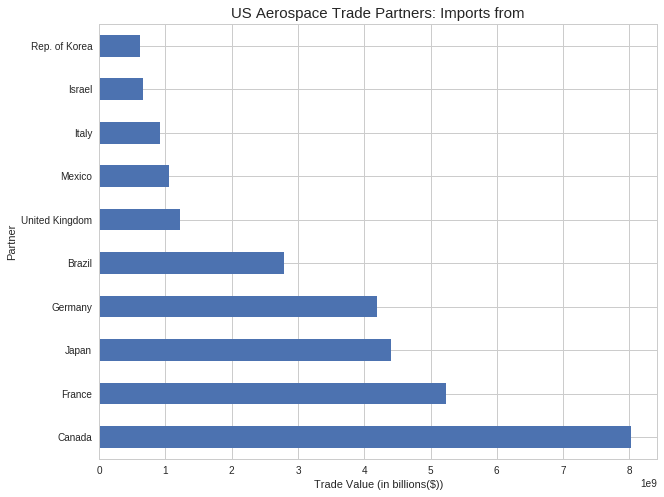

In [77]:
importPlot = totalImports.head(10).plot(kind='barh',figsize=(10,8))
importPlot.set_xlabel('Trade Value (in billions($))')
importPlot.set_title('US Aerospace Trade Partners: Imports from',fontsize=15)

In [70]:
exports = aero_countries[aero_countries[FLOW] == 'Exports']
grouped = exports.groupby([PARTNER])
print('The US exports to', len(grouped), 'countries.')
print('The 10 biggest importers from the US are:')
totalExports = grouped[VALUE].aggregate(sum).order(ascending=False).head(10)
totalExports.head(10)

The US exports to 206 countries.
The 10 biggest importers from the US are:


Partner
China                   14303821644
France                   9725457634
United Kingdom           8740175923
Canada                   6872391294
Japan                    6579615962
Germany                  6174837938
Singapore                5339173478
United Arab Emirates     5260733421
Brazil                   4359290177
Rep. of Korea            4068615966
Name: Trade Value (US$), dtype: int64

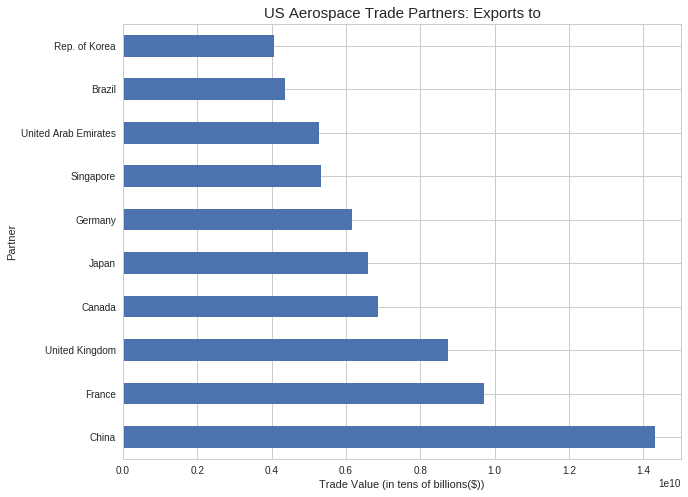

In [81]:
exportPlot= totalExports.head(10).plot(kind='barh',figsize=(10,8))
exportPlot.set_xlabel('Trade Value (in tens of billions($))')
exportPlot.set_title('US Aerospace Trade Partners: Exports to',fontsize=15)

## Bi-directional trade

To address the fourth question, 
'Which countries does the US both import from and export to?', a pivot table is used to list the total export and import value for each country. 

In [72]:
countries = pivot_table(aero, index=[PARTNER], columns=[FLOW], 
                        values=VALUE, aggfunc=sum)
countries.head()

Trade Flow,Exports,Imports
Partner,,
Afghanistan,109194100.0,20144.0
Albania,11616.0,NaN
Algeria,137157742.0,NaN
Andorra,10693.0,NaN
Angola,34332223.0,NaN


Removing the rows with a missing value will result in only those countries with bi-directional trade flow with the US.

In [73]:
countries.dropna()

Trade Flow,Exports,Imports
Partner,,
Afghanistan,1.091941e+08,2.014400e+04
Argentina,4.752256e+08,2.164540e+05
Australia,2.500375e+09,4.398146e+08
Austria,2.004885e+08,2.266043e+08
Bahamas,4.666452e+06,4.925000e+03
Belgium,3.811802e+08,5.153711e+07
Belize,8.897500e+05,6.451000e+03
Bolivia,1.236449e+08,1.837510e+05
Br. Virgin Isds,3.410660e+05,2.628000e+03


## Conclusions

US aerospace trade from January to December 2015 was analysed in terms of which countries the US  depends on for income (exports) and goods (imports). This industry enjoyed a positive trade balance, also known as a surplus. Over this period, the surplus had a value of over 174.2 billion US dollars. 

Canada is America's main aerospace trade partner. It exported to the US more than a billion more dollars worth of equipment than it imported from the US. France, Japan and Germany are also major trade partners with the US, but they imported more aircraft and parts from the US than they exported.

China is an important US aircraft customer, with China importing over $14 billion worth of American aerospace products. Interestingly, the US currently has a trade embargo against China, barring it from purchasing US weapons and military technology as a reprimand for the 1989 Tienanmen Square massacre. That China can still purchase so much non-military related hardware from the United States is impressive.

The US exported aerospace products to over 200 countries in 2015, but only imported from 87 countries, the main trade partners (top five by trade value) are Europe, Canada, Japan, Mexico and Brazil.

The US has bi-directional trade (i.e. both exports and imports) with hundreds of countries, although for some the trade value (in US dollars) is low, which raises questions about the data's relevance.

The US aircraft manufacturing industry is a vibrant and massively successful sector of the US economy. It's not only valuable for the United States, it also serves a vital role fulfilling the aviation needs of countries around the world. That so many countries have come to depend on the United States for quality aircraft and parts is a testament to this crucial industry.